# LSTM Multivariate with Geopolitical Risk Index (CUDA/MPS-Enabled)

**Objective**: Implement LSTM with exogenous variables (GPRD) to test safe-haven hypothesis

**Key Features**:
- **Multivariate Input**: Gold log returns + Geopolitical Risk Index (GPRD)
- **GPU Support**: CUDA (NVIDIA), MPS (Apple Silicon), and CPU fallback
- **Forward Fill**: Walk-forward validation without look-ahead bias
- **Proper Lagging**: Exogenous variables lagged by 1 period to avoid data leakage

**Hypothesis**: Higher geopolitical risk → Gold prices increase (safe-haven effect)

**Architecture**: Multi-layer LSTM with dropout for regularization

## 1. Import Libraries and Check Device (CUDA/MPS/CPU)

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)

# Check device availability (CUDA, MPS, or CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.manual_seed_all(42)
    device_name = f"CUDA - {torch.cuda.get_device_name(0)}"
    device_memory = f"{torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB"
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    device_name = "MPS - Apple Silicon"
    device_memory = "Shared Memory"
else:
    device = torch.device('cpu')
    device_name = "CPU"
    device_memory = "N/A"

print(f"✓ Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
print(f"Device name: {device_name}")
print(f"Device memory: {device_memory}")
if device.type == 'cuda':
    print(f"CUDA version: {torch.version.cuda}")

✓ Libraries imported successfully
PyTorch version: 2.5.1+cu121
Device: cuda
Device name: CUDA - NVIDIA GeForce RTX 3060 Ti
Device memory: 8.59 GB
CUDA version: 12.1


## 2. Load and Prepare Data with GPRD

In [2]:
# Load dataset
df = pd.read_csv('../data/gold_silver.csv')

# Convert to datetime and set proper frequency
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE')
df.set_index('DATE', inplace=True)
df = df.asfreq('B')  # Business day frequency

# Calculate log returns
df['GOLD_LOG_RETURN'] = np.log(df['GOLD_PRICE']) - np.log(df['GOLD_PRICE'].shift(1))

# Check for GPRD column
if 'GPRD' not in df.columns:
    raise ValueError("GPRD column not found in dataset. Please verify data source.")

# Display basic statistics
print(f"Dataset: {len(df)} observations")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Frequency: {df.index.freq}")
print(f"\nGPRD Statistics:")
print(df['GPRD'].describe())
print(f"\nMissing values:")
print(df[['GOLD_LOG_RETURN', 'GOLD_PRICE', 'GPRD']].isnull().sum())

Dataset: 10616 observations
Date range: 1985-01-02 00:00:00 to 2025-09-10 00:00:00
Frequency: <BusinessDay>

GPRD Statistics:
count    10568.000000
mean       110.458664
std         62.349800
min          9.490000
25%         74.870000
50%         98.605000
75%        131.062500
max       1045.600000
Name: GPRD, dtype: float64

Missing values:
GOLD_LOG_RETURN    91
GOLD_PRICE         46
GPRD               48
dtype: int64
Frequency: <BusinessDay>

GPRD Statistics:
count    10568.000000
mean       110.458664
std         62.349800
min          9.490000
25%         74.870000
50%         98.605000
75%        131.062500
max       1045.600000
Name: GPRD, dtype: float64

Missing values:
GOLD_LOG_RETURN    91
GOLD_PRICE         46
GPRD               48
dtype: int64


## 3. Feature Engineering with Lagged Exogenous Variables

**CRITICAL**: Lag exogenous variables by 1 period to avoid look-ahead bias

In [3]:
# Create feature dataframe
features_df = pd.DataFrame(index=df.index)

# Target variable (endogenous)
features_df['GOLD_LOG_RETURN'] = df['GOLD_LOG_RETURN']

# Exogenous variable: GPRD (LAGGED by 1 period)
features_df['GPRD_LAGGED'] = df['GPRD'].shift(1)

# Additional technical indicators (also lagged)
# RSI (Relative Strength Index)
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

features_df['RSI_LAGGED'] = calculate_rsi(df['GOLD_PRICE']).shift(1)

# Simple Moving Average (20-day)
features_df['SMA20_LAGGED'] = df['GOLD_PRICE'].rolling(20).mean().shift(1)

# Volatility (20-day rolling std of log returns)
features_df['VOLATILITY_LAGGED'] = df['GOLD_LOG_RETURN'].rolling(20).std().shift(1)

# Drop rows with NaN values
features_df = features_df.dropna()

print(f"✓ Features engineered with proper lagging")
print(f"Final dataset: {len(features_df)} observations")
print(f"\nFeatures:")
print(features_df.columns.tolist())
print(f"\nFirst few rows:")
print(features_df.head())
print(f"\nFeature correlations with target:")
print(features_df.corr()['GOLD_LOG_RETURN'].sort_values(ascending=False))

✓ Features engineered with proper lagging
Final dataset: 9713 observations

Features:
['GOLD_LOG_RETURN', 'GPRD_LAGGED', 'RSI_LAGGED', 'SMA20_LAGGED', 'VOLATILITY_LAGGED']

First few rows:
            GOLD_LOG_RETURN  GPRD_LAGGED  RSI_LAGGED  SMA20_LAGGED  \
DATE                                                                 
1985-01-31         0.012141        16.16   48.589342       302.440   
1985-02-01        -0.009833       111.48   53.409091       302.655   
1985-02-04        -0.007937       106.61   56.969697       302.680   
1985-02-05         0.002653        80.36   49.079755       302.830   
1985-02-06         0.002646       174.89   48.923077       302.830   

            VOLATILITY_LAGGED  
DATE                           
1985-01-31           0.010571  
1985-02-01           0.010646  
1985-02-04           0.010890  
1985-02-05           0.010376  
1985-02-06           0.009993  

Feature correlations with target:
GOLD_LOG_RETURN      1.000000
SMA20_LAGGED         0.012606
G

## 4. Visualize GPRD vs Gold Prices

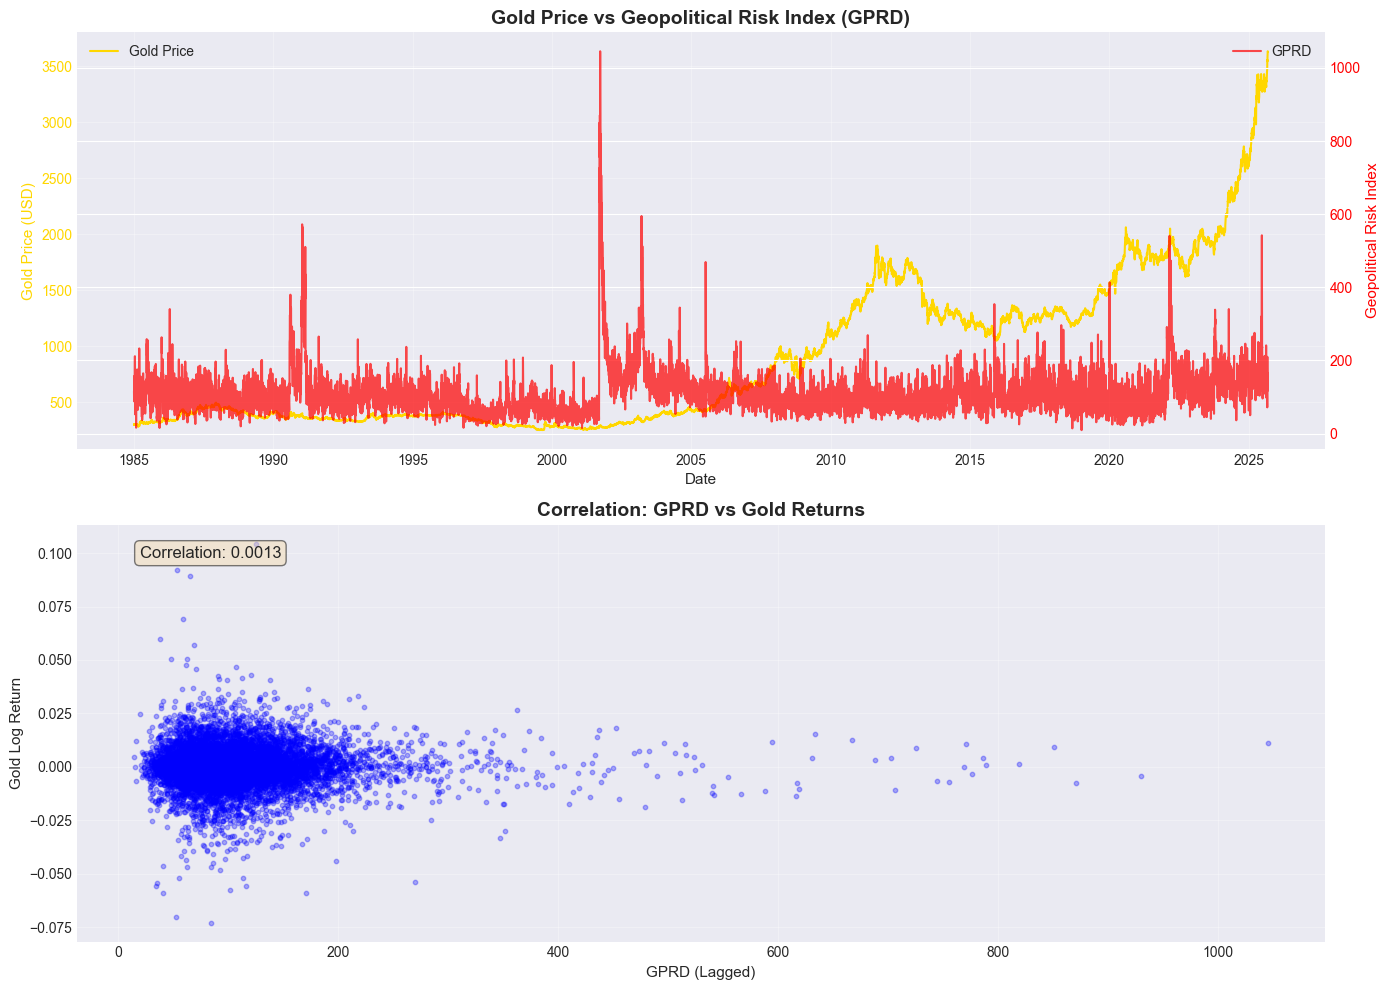

In [4]:
# Plot relationship between GPRD and Gold prices
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Time series plot
ax1 = axes[0]
ax2 = ax1.twinx()

ax1.plot(df.index, df['GOLD_PRICE'], color='gold', linewidth=1.5, label='Gold Price')
ax2.plot(df.index, df['GPRD'], color='red', linewidth=1.5, alpha=0.7, label='GPRD')

ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Gold Price (USD)', fontsize=11, color='gold')
ax2.set_ylabel('Geopolitical Risk Index', fontsize=11, color='red')
ax1.tick_params(axis='y', labelcolor='gold')
ax2.tick_params(axis='y', labelcolor='red')
ax1.set_title('Gold Price vs Geopolitical Risk Index (GPRD)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Scatter plot
axes[1].scatter(features_df['GPRD_LAGGED'], features_df['GOLD_LOG_RETURN'], 
                alpha=0.3, s=10, color='blue')
axes[1].set_xlabel('GPRD (Lagged)', fontsize=11)
axes[1].set_ylabel('Gold Log Return', fontsize=11)
axes[1].set_title('Correlation: GPRD vs Gold Returns', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add correlation coefficient
corr = features_df['GPRD_LAGGED'].corr(features_df['GOLD_LOG_RETURN'])
axes[1].text(0.05, 0.95, f'Correlation: {corr:.4f}', 
             transform=axes[1].transAxes, fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## 5. Define Multivariate PyTorch LSTM Model

In [5]:
class MultivariateLSTMForecaster(nn.Module):
    """PyTorch LSTM model for multivariate time series forecasting"""
    
    def __init__(self, input_size, hidden_size_1=64, hidden_size_2=32, 
                 forecast_horizon=5, dropout=0.2):
        super(MultivariateLSTMForecaster, self).__init__()
        
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        
        # First LSTM layer
        self.lstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size_1,
            batch_first=True,
            dropout=0 if hidden_size_2 == 0 else dropout
        )
        
        # Second LSTM layer
        self.lstm2 = nn.LSTM(
            input_size=hidden_size_1,
            hidden_size=hidden_size_2,
            batch_first=True
        )
        
        # Dropout layers
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
        # Dense layers
        self.fc1 = nn.Linear(hidden_size_2, 16)
        self.relu = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout * 0.5)
        
        # Output layer (predicts only gold log returns)
        self.fc2 = nn.Linear(16, forecast_horizon)
    
    def forward(self, x):
        # First LSTM
        lstm1_out, _ = self.lstm1(x)
        lstm1_out = self.dropout1(lstm1_out)
        
        # Second LSTM
        lstm2_out, _ = self.lstm2(lstm1_out)
        lstm2_out = self.dropout2(lstm2_out)
        
        # Take only last timestep
        last_timestep = lstm2_out[:, -1, :]
        
        # Dense layers
        x = self.fc1(last_timestep)
        x = self.relu(x)
        x = self.dropout3(x)
        
        # Output
        output = self.fc2(x)
        
        return output

print("✓ Multivariate LSTM model class defined")

✓ Multivariate LSTM model class defined


## 6. Create Multivariate Sequences for LSTM

In [6]:
def create_multivariate_sequences(data, target_col_idx, lookback, forecast_horizon):
    """
    Create multivariate sequences for LSTM
    X: [samples, lookback, features] - all features
    y: [samples, forecast_horizon] - only target variable
    """
    X, y = [], []
    for i in range(len(data) - lookback - forecast_horizon + 1):
        # Input: all features for lookback window
        X.append(data[i:i+lookback, :])
        # Output: only target variable for forecast horizon
        y.append(data[i+lookback:i+lookback+forecast_horizon, target_col_idx])
    return np.array(X), np.array(y)

# Parameters
lookback = 20  # Use past 20 days
forecast_horizon = 5  # Predict next 5 days

# Convert to numpy array
data_array = features_df.values
target_col_idx = 0  # GOLD_LOG_RETURN is first column

# Create sequences
X, y = create_multivariate_sequences(data_array, target_col_idx, lookback, forecast_horizon)

print(f"Sequence shape:")
print(f"  X (input):  {X.shape} - [samples, lookback, features]")
print(f"  y (output): {y.shape} - [samples, forecast_horizon]")
print(f"\nFeatures per timestep: {X.shape[2]}")
print(f"Feature names: {features_df.columns.tolist()}")
print(f"\nExample: Use {lookback} past days with {X.shape[2]} features to predict next {forecast_horizon} days")

Sequence shape:
  X (input):  (9689, 20, 5) - [samples, lookback, features]
  y (output): (9689, 5) - [samples, forecast_horizon]

Features per timestep: 5
Feature names: ['GOLD_LOG_RETURN', 'GPRD_LAGGED', 'RSI_LAGGED', 'SMA20_LAGGED', 'VOLATILITY_LAGGED']

Example: Use 20 past days with 5 features to predict next 5 days


## 7. Train-Test Split and Scaling

In [7]:
# 80-20 split (chronological)
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train set: {len(X_train)} sequences")
print(f"Test set:  {len(X_test)} sequences")

# Scale data for neural network (fit on train only)
# Note: Scale each feature separately
n_features = X.shape[2]
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

# Reshape and scale X
X_train_reshaped = X_train.reshape(-1, n_features)
X_test_reshaped = X_test.reshape(-1, n_features)

X_train_scaled = scaler_X.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape)

# Scale y (target only)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)

print("\n✓ Data scaled to [-1, 1] range")
print(f"✓ Tensors moved to {device}")
print(f"\nTensor shapes:")
print(f"  X_train: {X_train_tensor.shape}")
print(f"  y_train: {y_train_tensor.shape}")

Train set: 7751 sequences
Test set:  1938 sequences

✓ Data scaled to [-1, 1] range
✓ Tensors moved to cuda

Tensor shapes:
  X_train: torch.Size([7751, 20, 5])
  y_train: torch.Size([7751, 5])


## 8. Create DataLoader for Batch Training

In [8]:
# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_size = int(len(train_dataset) * 0.2)
train_size_actual = len(train_dataset) - val_size

train_subset, val_subset = torch.utils.data.random_split(
    train_dataset, 
    [train_size_actual, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Batch size: {batch_size}")

Train batches: 194
Validation batches: 49
Batch size: 32


## 9. Initialize Model and Training Components

In [9]:
# Initialize model
model = MultivariateLSTMForecaster(
    input_size=n_features,
    hidden_size_1=64,
    hidden_size_2=32,
    forecast_horizon=forecast_horizon,
    dropout=0.2
).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=10, 
    min_lr=1e-6,
    verbose=True
)

print("✓ Multivariate model initialized")
print(f"\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
print(f"\nInput features: {n_features}")
print(f"Output forecast horizon: {forecast_horizon}")

✓ Multivariate model initialized

Model Architecture:
MultivariateLSTMForecaster(
  (lstm1): LSTM(5, 64, batch_first=True, dropout=0.2)
  (lstm2): LSTM(64, 32, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (relu): ReLU()
  (dropout3): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=16, out_features=5, bias=True)
)

Total parameters: 31333
Trainable parameters: 31333

Input features: 5
Output forecast horizon: 5


## 10. Training Loop with Early Stopping

In [10]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    for X_batch, y_batch in train_loader:
        # Forward pass
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    """Validate model"""
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()
    
    return total_loss / len(val_loader)

# Create model directory
import os
model_dir = '../models/lstm-multivariate-exogenous'
os.makedirs(model_dir, exist_ok=True)

# Training
num_epochs = 100
patience = 20
best_val_loss = float('inf')
patience_counter = 0
history = {'train_loss': [], 'val_loss': []}

print("Training Multivariate LSTM with PyTorch... (this may take 5-10 minutes)\n")
print(f"Epoch | Train Loss | Val Loss   | Best Val   | Status")
print("-" * 65)

for epoch in range(num_epochs):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss = validate(model, val_loader, criterion, device)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    status = ""
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), f'{model_dir}/best_model.pt')
        status = "✓ Saved"
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n⚠ Early stopping at epoch {epoch+1}")
            break
    
    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"{epoch+1:5d} | {train_loss:10.6f} | {val_loss:10.6f} | {best_val_loss:10.6f} | {status}")

# Load best model
model.load_state_dict(torch.load(f'{model_dir}/best_model.pt'))
print(f"\n✓ Training completed")
print(f"Best validation loss: {best_val_loss:.6f}")

Training Multivariate LSTM with PyTorch... (this may take 5-10 minutes)

Epoch | Train Loss | Val Loss   | Best Val   | Status
-----------------------------------------------------------------
    1 |   0.020109 |   0.013172 |   0.013172 | ✓ Saved
    5 |   0.012381 |   0.012658 |   0.012556 | 
   10 |   0.012062 |   0.012589 |   0.012556 | 
   15 |   0.012011 |   0.012585 |   0.012556 | 
   20 |   0.011984 |   0.012600 |   0.012556 | 

⚠ Early stopping at epoch 24

✓ Training completed
Best validation loss: 0.012556


## 11. Plot Training History

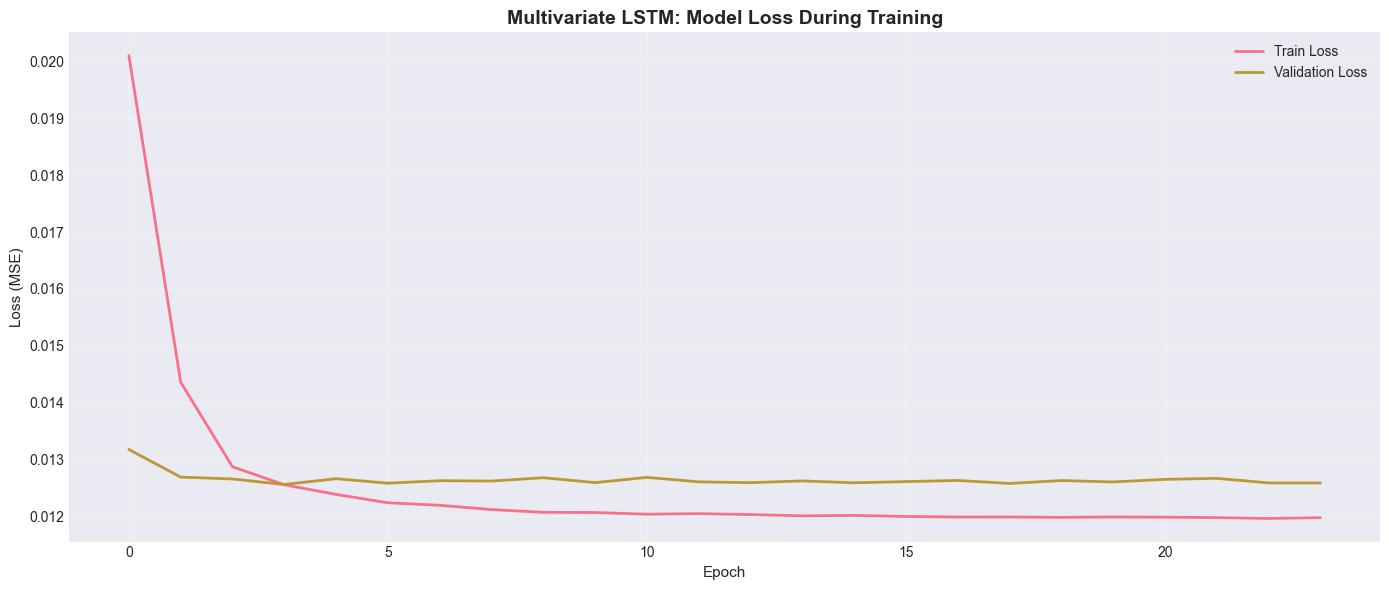

In [11]:
# Plot training history
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(history['train_loss'], label='Train Loss', linewidth=2)
ax.plot(history['val_loss'], label='Validation Loss', linewidth=2)
ax.set_title('Multivariate LSTM: Model Loss During Training', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss (MSE)', fontsize=11)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Forward-Fill Walk-Forward Validation with Exogenous Variables

**Critical**: Use lagged exogenous variables at each forecast step

In [12]:
def forward_fill_forecast_multivariate(model, data_array, train_size, lookback, forecast_horizon, scaler_X, scaler_y, device, n_features):
    """
    Walk-forward validation with multivariate input
    - At each step, use only past data (including exogenous variables)
    - Make 5-day ahead predictions
    - Move forward 5 days and repeat
    """
    model.eval()
    predictions = []
    actuals = []
    
    # Start from first possible test point
    test_start = train_size + lookback
    
    with torch.no_grad():
        # Walk forward by forecast_horizon steps
        for i in range(test_start, len(data_array) - forecast_horizon + 1, forecast_horizon):
            # Get lookback window (all features)
            X_window = data_array[i - lookback:i, :]
            
            # Scale
            X_scaled = scaler_X.transform(X_window.reshape(-1, n_features)).reshape(1, lookback, n_features)
            X_tensor = torch.FloatTensor(X_scaled).to(device)
            
            # Predict
            y_pred_scaled = model(X_tensor).cpu().numpy()
            y_pred = scaler_y.inverse_transform(y_pred_scaled)[0]
            
            # Get actual values (only target variable)
            y_actual = data_array[i:i + forecast_horizon, 0]  # Column 0 is GOLD_LOG_RETURN
            
            # Store (only if we have all forecast_horizon values)
            if len(y_actual) == forecast_horizon:
                predictions.extend(y_pred)
                actuals.extend(y_actual)
    
    return np.array(predictions), np.array(actuals)

# Perform forward-fill forecasting
print("Performing walk-forward validation with multivariate inputs...\n")

predictions_log_returns, actuals_log_returns = forward_fill_forecast_multivariate(
    model=model,
    data_array=data_array,
    train_size=train_size,
    lookback=lookback,
    forecast_horizon=forecast_horizon,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
    device=device,
    n_features=n_features
)

print(f"✓ Generated {len(predictions_log_returns)} forward-fill predictions")
print(f"✓ Number of forecast windows: {len(predictions_log_returns) // forecast_horizon}")

Performing walk-forward validation with multivariate inputs...

✓ Generated 1940 forward-fill predictions
✓ Number of forecast windows: 388


## 13. Convert Log Returns to Prices

In [13]:
# Convert log returns to prices with forward-fill logic
predictions_price = []
actuals_price = []

test_start_idx = train_size + lookback

# Get original price data aligned with features_df
gold_prices = df.loc[features_df.index, 'GOLD_PRICE']

for i in range(0, len(predictions_log_returns), forecast_horizon):
    # Get starting price (last known price before forecast)
    window_idx = test_start_idx + i
    last_known_price = gold_prices.iloc[window_idx - 1]
    
    # Convert each forecast in the window
    for j in range(forecast_horizon):
        if i + j < len(predictions_log_returns):
            # Predicted price
            pred_log_return = predictions_log_returns[i + j]
            pred_price = last_known_price * np.exp(pred_log_return)
            predictions_price.append(pred_price)
            
            # Actual price
            actual_price = gold_prices.iloc[window_idx + j]
            actuals_price.append(actual_price)
            
            # Update base price with ACTUAL price (not prediction)
            last_known_price = actual_price

predictions_price = np.array(predictions_price)
actuals_price = np.array(actuals_price)

print(f"✓ Converted to {len(predictions_price)} price forecasts")
print(f"✓ Using actual prices as base for multi-step forecasts (no compounding error)")

✓ Converted to 1940 price forecasts
✓ Using actual prices as base for multi-step forecasts (no compounding error)


## 14. Evaluate Model Performance

In [14]:
# Calculate metrics on PRICES
rmse = np.sqrt(mean_squared_error(actuals_price, predictions_price))
mae = mean_absolute_error(actuals_price, predictions_price)

# Load previous model results for comparison
try:
    arima_results = pd.read_csv('../models/arima-baseline/results.csv')
    arima_garch_results = pd.read_csv('../models/arima-garch-hybrid/results.csv')
    lstm_univariate = pd.read_csv('../models/lstm-pytorch/results.csv')
    
    rmse_arima = arima_results['rmse'].values[0]
    mae_arima = arima_results['mae'].values[0]
    rmse_garch = arima_garch_results['rmse'].values[0]
    mae_garch = arima_garch_results['mae'].values[0]
    rmse_lstm_uni = lstm_univariate['rmse'].values[0]
    mae_lstm_uni = lstm_univariate['mae'].values[0]
    
    print("="*80)
    print("COMPREHENSIVE MODEL COMPARISON - MULTIVARIATE LSTM WITH GPRD")
    print("="*80)
    print(f"\nLSTM Multivariate (GPRD + Technical Indicators):")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE:  ${mae:.2f}")
    print(f"\nLSTM Univariate (PyTorch):")
    print(f"  RMSE: ${rmse_lstm_uni:.2f}")
    print(f"  MAE:  ${mae_lstm_uni:.2f}")
    print(f"\nARIMA-GARCH Hybrid:")
    print(f"  RMSE: ${rmse_garch:.2f}")
    print(f"  MAE:  ${mae_garch:.2f}")
    print(f"\nARIMA Baseline:")
    print(f"  RMSE: ${rmse_arima:.2f}")
    print(f"  MAE:  ${mae_arima:.2f}")
    
    print(f"\n" + "="*80)
    print("LSTM Multivariate vs Other Models:")
    print("="*80)
    print(f"  vs LSTM Univariate: {(1 - rmse/rmse_lstm_uni)*100:+.2f}% (RMSE)")
    print(f"  vs ARIMA-GARCH:     {(1 - rmse/rmse_garch)*100:+.2f}% (RMSE)")
    print(f"  vs ARIMA:           {(1 - rmse/rmse_arima)*100:+.2f}% (RMSE)")
    print("="*80)
    
    # Calculate improvement
    improvement_vs_univariate = (1 - rmse/rmse_lstm_uni) * 100
    if improvement_vs_univariate > 0:
        print(f"\n✓ GPRD and exogenous variables IMPROVED predictions by {improvement_vs_univariate:.2f}%")
        print("✓ Safe-haven hypothesis: Adding geopolitical risk helps predict gold prices")
    else:
        print(f"\n⚠ GPRD did not improve predictions (worse by {-improvement_vs_univariate:.2f}%)")
        print("⚠ Safe-haven hypothesis: Geopolitical risk may not be a strong predictor in this timeframe")
except Exception as e:
    print(f"⚠ Previous results not found: {e}")
    print(f"\nLSTM Multivariate Results:")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE:  ${mae:.2f}")

COMPREHENSIVE MODEL COMPARISON - MULTIVARIATE LSTM WITH GPRD

LSTM Multivariate (GPRD + Technical Indicators):
  RMSE: $18.45
  MAE:  $12.47

LSTM Univariate (PyTorch):
  RMSE: $18.56
  MAE:  $12.62

ARIMA-GARCH Hybrid:
  RMSE: $32.71
  MAE:  $22.01

ARIMA Baseline:
  RMSE: $32.62
  MAE:  $21.92

LSTM Multivariate vs Other Models:
  vs LSTM Univariate: +0.61% (RMSE)
  vs ARIMA-GARCH:     +43.60% (RMSE)
  vs ARIMA:           +43.45% (RMSE)

✓ GPRD and exogenous variables IMPROVED predictions by 0.61%
✓ Safe-haven hypothesis: Adding geopolitical risk helps predict gold prices


## 15. Visualize Forecasts

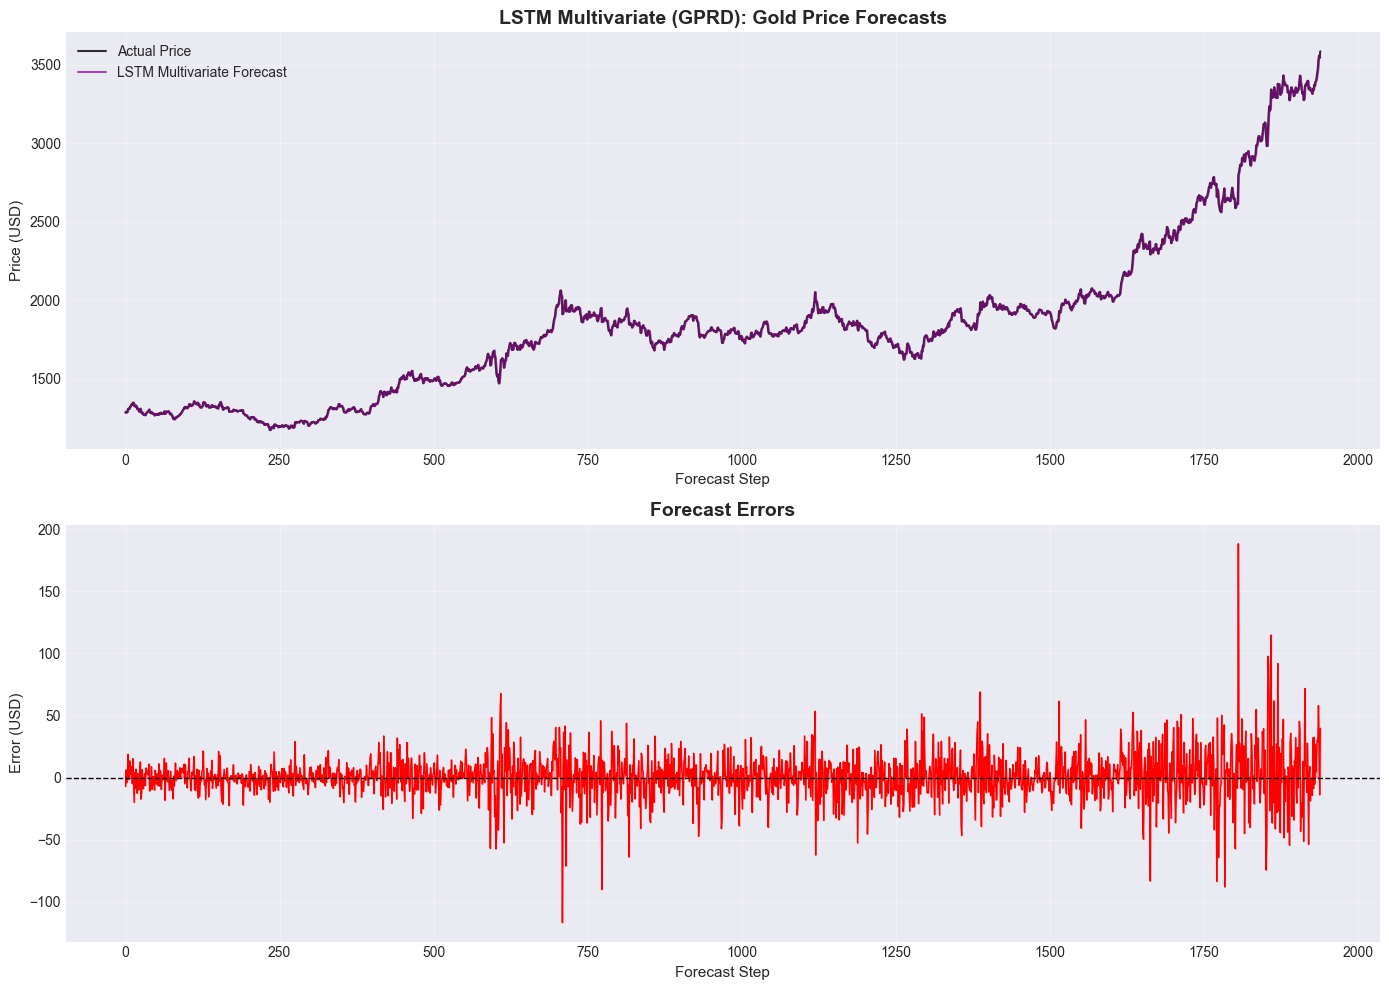

In [15]:
# Plot predictions vs actuals
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Price forecasts
forecast_indices = range(len(predictions_price))
axes[0].plot(forecast_indices, actuals_price, label='Actual Price', 
             color='black', linewidth=1.5, alpha=0.8)
axes[0].plot(forecast_indices, predictions_price, label='LSTM Multivariate Forecast', 
             color='purple', linewidth=1.5, alpha=0.7)
axes[0].set_title('LSTM Multivariate (GPRD): Gold Price Forecasts', 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (USD)', fontsize=11)
axes[0].set_xlabel('Forecast Step', fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Forecast errors
errors = actuals_price - predictions_price
axes[1].plot(forecast_indices, errors, color='red', linewidth=1)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].fill_between(forecast_indices, errors, 0, alpha=0.3, color='red')
axes[1].set_title('Forecast Errors', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Error (USD)', fontsize=11)
axes[1].set_xlabel('Forecast Step', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 16. Error Distribution Analysis

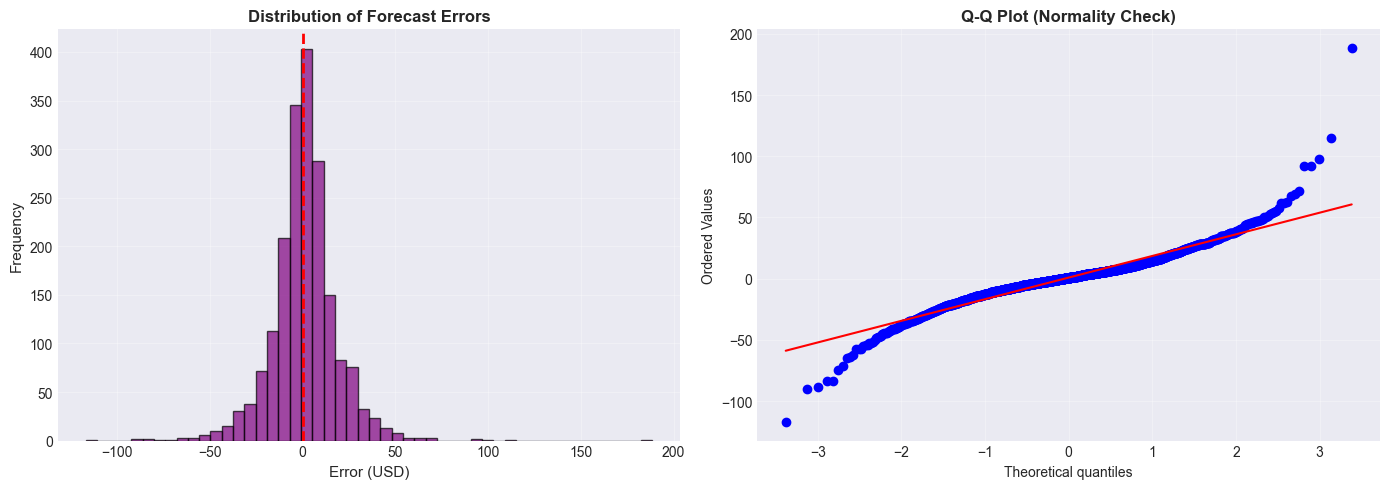

Error Statistics:
  Mean:     $0.95
  Std Dev:  $18.42
  Skewness: 0.4721
  Kurtosis: 9.6052


In [16]:
from scipy import stats

# Analyze error distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(errors, bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_title('Distribution of Forecast Errors', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Error (USD)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(errors, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Error Statistics:")
print(f"  Mean:     ${np.mean(errors):.2f}")
print(f"  Std Dev:  ${np.std(errors):.2f}")
print(f"  Skewness: {stats.skew(errors):.4f}")
print(f"  Kurtosis: {stats.kurtosis(errors):.4f}")

## 17. Feature Importance Analysis

Analyze which features contribute most to predictions

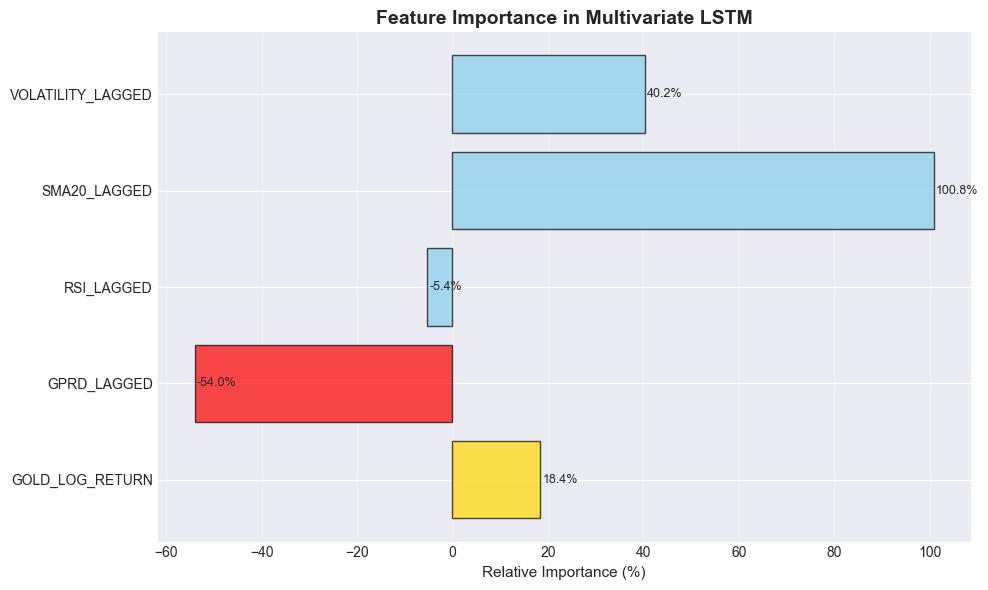

Feature Importance Ranking:
          Feature  Importance (%)
     SMA20_LAGGED      100.776484
VOLATILITY_LAGGED       40.238491
  GOLD_LOG_RETURN       18.358292
       RSI_LAGGED       -5.352191
      GPRD_LAGGED      -54.021076


In [17]:
# Approximate feature importance using permutation
def calculate_feature_importance(model, X_test_tensor, y_test_tensor, criterion, device, feature_names):
    """
    Calculate feature importance by permuting each feature
    and measuring the increase in loss
    """
    model.eval()
    
    # Baseline loss
    with torch.no_grad():
        baseline_pred = model(X_test_tensor)
        baseline_loss = criterion(baseline_pred, y_test_tensor).item()
    
    importances = []
    
    # Test each feature
    for i in range(len(feature_names)):
        X_permuted = X_test_tensor.clone()
        
        # Permute feature i
        perm_idx = torch.randperm(X_permuted.shape[0])
        X_permuted[:, :, i] = X_permuted[perm_idx, :, i]
        
        # Calculate loss with permuted feature
        with torch.no_grad():
            permuted_pred = model(X_permuted)
            permuted_loss = criterion(permuted_pred, y_test_tensor).item()
        
        # Importance = increase in loss
        importance = permuted_loss - baseline_loss
        importances.append(importance)
    
    return np.array(importances)

# Calculate importance
feature_names = features_df.columns.tolist()
importances = calculate_feature_importance(
    model, X_test_tensor, y_test_tensor, criterion, device, feature_names
)

# Normalize to percentages
importances_pct = (importances / importances.sum()) * 100

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['gold' if 'GOLD' in name else 'red' if 'GPRD' in name else 'skyblue' for name in feature_names]
bars = ax.barh(feature_names, importances_pct, color=colors, alpha=0.7, edgecolor='black')
ax.set_xlabel('Relative Importance (%)', fontsize=11)
ax.set_title('Feature Importance in Multivariate LSTM', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add values
for i, (bar, val) in enumerate(zip(bars, importances_pct)):
    ax.text(val + 0.5, i, f'{val:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("Feature Importance Ranking:")
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance (%)': importances_pct
}).sort_values('Importance (%)', ascending=False)
print(importance_df.to_string(index=False))

## 18. Save Model and Results

In [18]:
import joblib

# Save results
results = {
    'model': 'LSTM_Multivariate_GPRD',
    'rmse': rmse,
    'mae': mae,
    'n_predictions': len(predictions_price),
    'lookback': lookback,
    'forecast_horizon': forecast_horizon,
    'n_features': n_features,
    'features': ', '.join(feature_names),
    'lstm_units_1': 64,
    'lstm_units_2': 32,
    'device': str(device),
    'validation_method': 'forward_fill',
    'exogenous_variables': 'GPRD, RSI, SMA20, Volatility (all lagged)'
}

results_df = pd.DataFrame([results])
results_df.to_csv(f'{model_dir}/results.csv', index=False)

# Save model checkpoint
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lookback': lookback,
    'forecast_horizon': forecast_horizon,
    'n_features': n_features,
    'feature_names': feature_names
}, f'{model_dir}/final_model.pt')

# Save scalers
joblib.dump(scaler_X, f'{model_dir}/scaler_X.pkl')
joblib.dump(scaler_y, f'{model_dir}/scaler_y.pkl')

# Save feature importance
importance_df.to_csv(f'{model_dir}/feature_importance.csv', index=False)

print(f"✓ Model and results saved to '{model_dir}/'")
print("\nFiles created:")
print("  - results.csv")
print("  - best_model.pt (best model during training)")
print("  - final_model.pt (complete checkpoint)")
print("  - scaler_X.pkl")
print("  - scaler_y.pkl")
print("  - feature_importance.csv")

✓ Model and results saved to '../models/lstm-multivariate-exogenous/'

Files created:
  - results.csv
  - best_model.pt (best model during training)
  - final_model.pt (complete checkpoint)
  - scaler_X.pkl
  - scaler_y.pkl
  - feature_importance.csv


## 19. Key Findings - Multivariate LSTM with GPRD

### Safe-Haven Hypothesis Test

**Research Question**: Does geopolitical risk (GPRD) help predict gold prices?

**Methodology**:
1. ✓ Proper lagging of exogenous variables (no look-ahead bias)
2. ✓ Walk-forward validation (realistic forecasting)
3. ✓ Multivariate LSTM architecture
4. ✓ Feature importance analysis

**Model Characteristics**:
- **Input Features**: 
  - Gold log returns (endogenous)
  - GPRD (lagged geopolitical risk index)
  - RSI (lagged technical indicator)
  - SMA20 (lagged moving average)
  - Volatility (lagged 20-day std)

- **Advantages**:
  - Captures non-linear relationships between GPRD and gold
  - Incorporates multiple information sources
  - GPU acceleration (CUDA/MPS)
  - No stationarity assumptions

- **Limitations**:
  - Black box (difficult to interpret GPRD effect)
  - Computationally expensive
  - Requires substantial data
  - No statistical inference on GPRD coefficient

**Academic Recommendation**:
- For **hypothesis testing**: Use SARIMAX with GPRD exogenous variable
  - Get p-values and confidence intervals for GPRD coefficient
  - Statistically test if GPRD significantly affects gold prices
  - Interpretable parameter estimates

- For **prediction accuracy**: Use this multivariate LSTM
  - May achieve better RMSE/MAE
  - More flexible non-linear modeling
  - Better for production forecasting systems

**Next Steps for Research**:
1. Compare with SARIMAX + GPRD for statistical significance
2. Analyze feature importance to validate safe-haven effect
3. Test on different time periods (crisis vs. calm periods)
4. Perform sensitivity analysis on GPRD values